In [1]:

arch_map = {'': 'Baseline',
            'AC': 'Adaptive Clipper',
            'MF': 'Median Filter',
            'ranger': 'Ranger',
            'SR': 'Swap ReLU6',
            'TMR': 'TMR'
 }

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

os.chdir("/home/bepi/Desktop/Ph.D_/projects/APP_FI/data/")
path = os.getcwd()

log_folders = [file_path for file_path in os.listdir("/home/bepi/Desktop/Ph.D_/projects/APP_FI/data/") if file_path.startswith("FSIM_W_HPC_mobilenet") and not file_path.endswith('gz')]
# print(log_folders)

general_report = pd.DataFrame([])
new_report = pd.DataFrame([])
for layer_conf in log_folders:
    model = layer_conf.split('_')[3]
    architecture = ''
    if len(layer_conf.split('_')) == 5:
        architecture = layer_conf.split('_')[4]
    if layer_conf != ".DS_Store":
        folder_path = os.path.join(path,  layer_conf)
        for cnf in [files for files in os.listdir(folder_path) if files != ".DS_Store" and not files.endswith('.log')]:
            file_path = os.path.join(folder_path, cnf)

            report_path = os.path.join(file_path, "fsim_full_report.csv")
            report = pd.read_csv(report_path)
            report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"

            report.drop(columns=['Unnamed: 0'], inplace=True)
            report['bit_faulty_pos']=np.log2(report['bitmask']).astype(int)
            
            report['MRAD']=abs(100*(report['fault_ACC@1']-report['gold_ACC@1'])/report['gold_ACC@1'])
            report['MRADk']=abs(100*(report['fault_ACC@k']-report['gold_ACC@k'])/report['gold_ACC@k'])
            report['AbsAD']=abs((report['fault_ACC@1']-report['gold_ACC@1']))
            report['AbsADk']=abs((report['fault_ACC@k']-report['gold_ACC@k']))

            report['MRF1D']=abs(100*(report['fault_f1@1']-report['goldenf1_1'])/report['goldenf1_1'])
            report['MRF1Dk']=abs(100*(report['fault_f1@k']-report['goldenf1_k'])/report['goldenf1_k'])
            report['AbsF1D']=abs((report['fault_f1@1']-report['goldenf1_1']))
            report['AbsF1Dk']=abs((report['fault_f1@k']-report['goldenf1_k']))

            report['MRRD']=abs(100*(report['fault_rec@1']-report['goldenrec_1'])/report['goldenrec_1'])
            report['MRRDk']=abs(100*(report['fault_rec@k']-report['goldenrec_k'])/report['goldenrec_k'])
            report['AbsrD']=abs((report['fault_rec@1']-report['goldenrec_1']))
            report['AbsRDk']=abs((report['fault_rec@k']-report['goldenrec_k']))

            report['MRPD']=abs(100*(report['fault_prec@1']-report['goldenprec_1'])/report['goldenprec_1'])
            report['MRPDk']=abs(100*(report['fault_prec@k']-report['goldenprec_k'])/report['goldenprec_k'])
            report['AbsPD']=abs((report['fault_prec@1']-report['goldenprec_1']))
            report['AbsPDk']=abs((report['fault_prec@k']-report['goldenprec_k']))
            report['Architecture'] = arch_map[architecture]
            general_report = pd.concat([general_report, report], axis=0, ignore_index=True)

            new_path = os.path.join(file_path, "Misclassified_images_report.csv")
            additional_report = pd.read_csv(new_path)
            additional_report['model'] = 'Mobilenet V2'
            additional_report['Architecture'] = arch_map[architecture]
            additional_report['bit_faulty_pos']=np.log2(report['bitmask']).astype(int)
            new_report = pd.concat([new_report, additional_report], axis=0, ignore_index=True)
            new_report['conf_detail'] = cnf.split("_")[0] if cnf.split("_")[0] != "cnf77" else "teacher_cnf"



In [4]:
general_report[general_report['Architecture'] == 'Swap ReLU6'][general_report['bit_faulty_pos']==30]['fault_ACC@1'].mean()


/tmp/ipykernel_16386/1453147259.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  general_report[general_report['Architecture'] == 'Swap ReLU6'][general_report['bit_faulty_pos']==30]['fault_ACC@1'].mean()


76.84971464806594

In [3]:
general_report[general_report['bit_faulty_pos']==30].groupby('Architecture')['fault_ACC@1'].mean()

Architecture
Adaptive Clipper    70.029884
Baseline            66.483837
Ranger              66.160429
Swap ReLU6          76.849715
Name: fault_ACC@1, dtype: float64

## Fault distribution

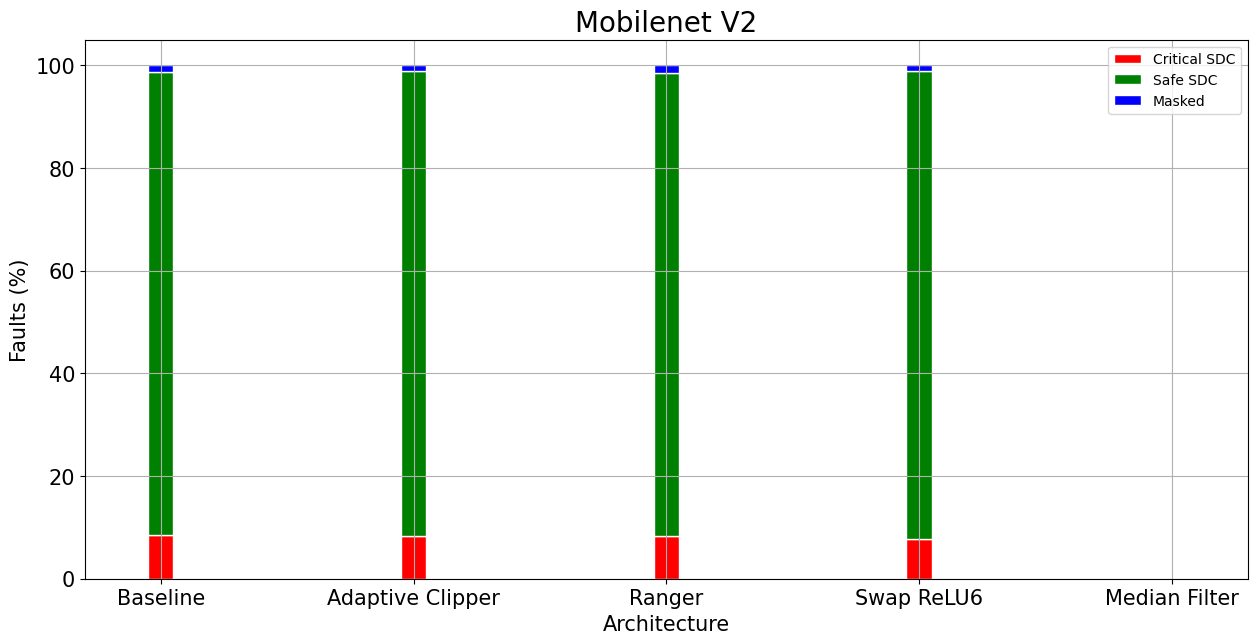

In [36]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(15,7))

general_report.rename(columns={'img_Top1_Crit': 'Critical SDC',
                       'img_Top1_SDC': 'Safe SDC',
                       'img_Top1_Masked': 'Masked'}, inplace=True)

grouped_fd = general_report[['Critical SDC', 'Safe SDC', 'Masked', 'Architecture']].groupby('Architecture').mean()
new_order = ['Baseline', 'Adaptive Clipper', 'Ranger', 'Swap ReLU6', 'Median Filter']
grouped_fd = grouped_fd.reindex(new_order)

grouped_fd.plot(kind='bar', stacked=True, color=['red', 'green', 'blue' ], edgecolor='white', width=0.1, ax = ax, legend=True, rot=0)
grouped_fd.to_csv('/home/bepi/Desktop/Ph.D_/projects/APP_FI/code/APP_Fault_injections/report_analysis/HardeningEvaluations/weights/mobilenetFD.csv')



ax.set_title('Mobilenet V2', fontsize=20)
ax.grid()
ax.set_ylabel('Faults (%)', fontsize=15)
ax.set_xlabel('Architecture', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

## Accuracy of the corrupted NN
#### (The accuracy is evaluated considering only the top1 prediction)

In [21]:
general_report['layer'].unique()

array([30, 33, 42,  0, 12,  3, 48, 15,  6, 24, 21,  9, 36, 50, 27, 18, 39,
       45, 51])

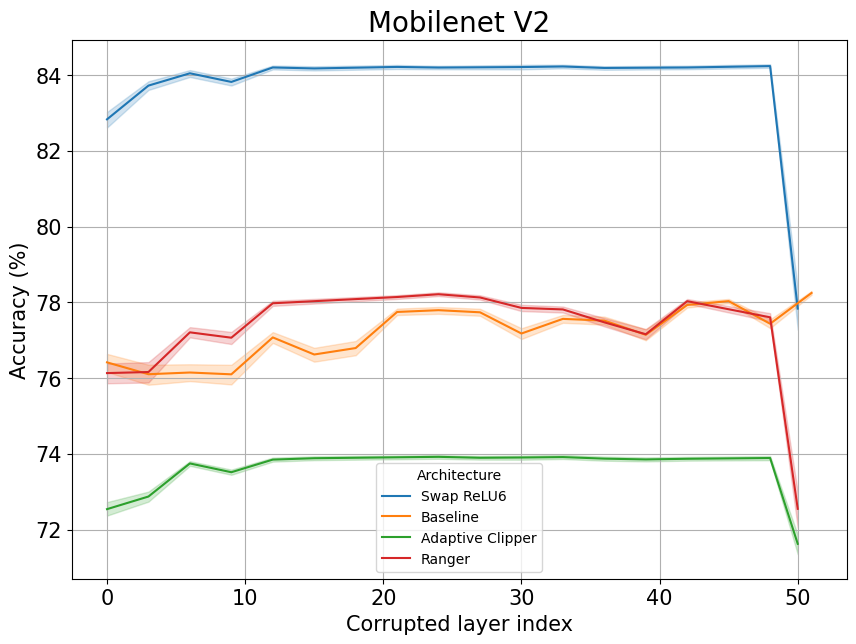

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
# sns.stripplot(data=general_report, x='layer', y='fault_ACC@1', hue='Architecture', ax = ax, dodge=True, alpha=.2)
sns.lineplot(data=general_report, x='layer', y='fault_ACC@1', hue='Architecture', ax = ax)
# sns.scatterplot(data=general_report, x='neuron_fault_rate', y='fault_ACC@1', hue='Architecture', ax = ax)
ax.set_title('Mobilenet V2', fontsize=20)
ax.grid()
ax.set_ylabel('Accuracy (%)', fontsize=15)
ax.set_xlabel('Corrupted layer index', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

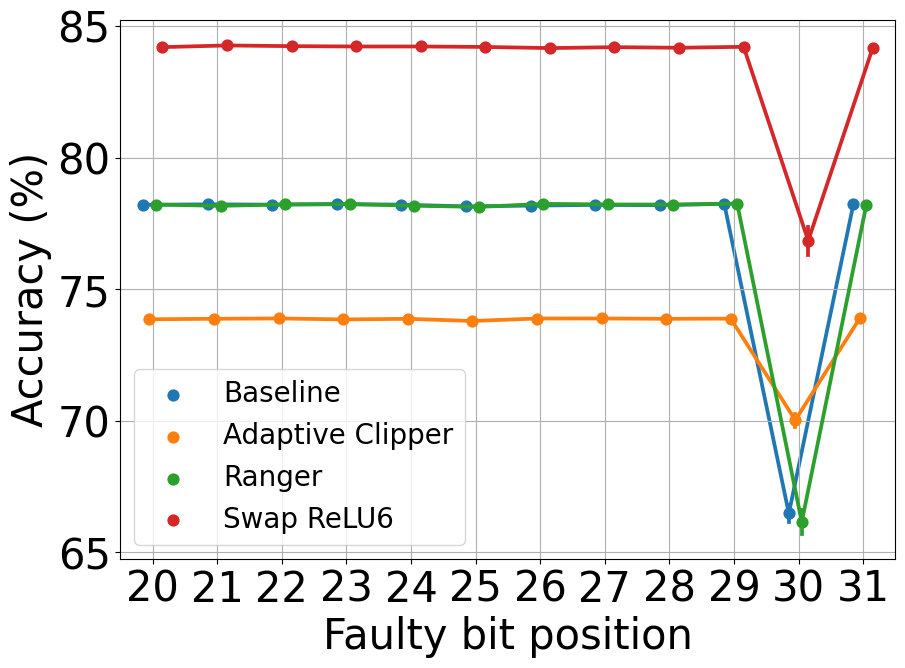

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
legend_order = ['Baseline', 'Adaptive Clipper', 'Ranger', 'Swap ReLU6']
# sns.stripplot(data=general_report, x='bit_faulty_pos', y='fault_ACC@1', hue='Architecture', ax = ax, dodge=True, alpha=.2)
sns.pointplot(data=general_report, x='bit_faulty_pos', y='fault_ACC@1', hue='Architecture', ax = ax, dodge=0.3, linestyle="none", markers="o", markersize=40, 
               legend=False, hue_order=legend_order)
# sns.scatterplot(data=general_report, x='neuron_fault_rate', y='fault_ACC@1', hue='Architecture', ax = ax)
# ax.set_title('LeNet5', fontsize=20)

ax.grid()
ax.legend(fontsize=20)
ax.set_ylabel('Accuracy (%)', fontsize=30)
ax.set_xlabel('Faulty bit position', fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)

### Let's isolate bit 30

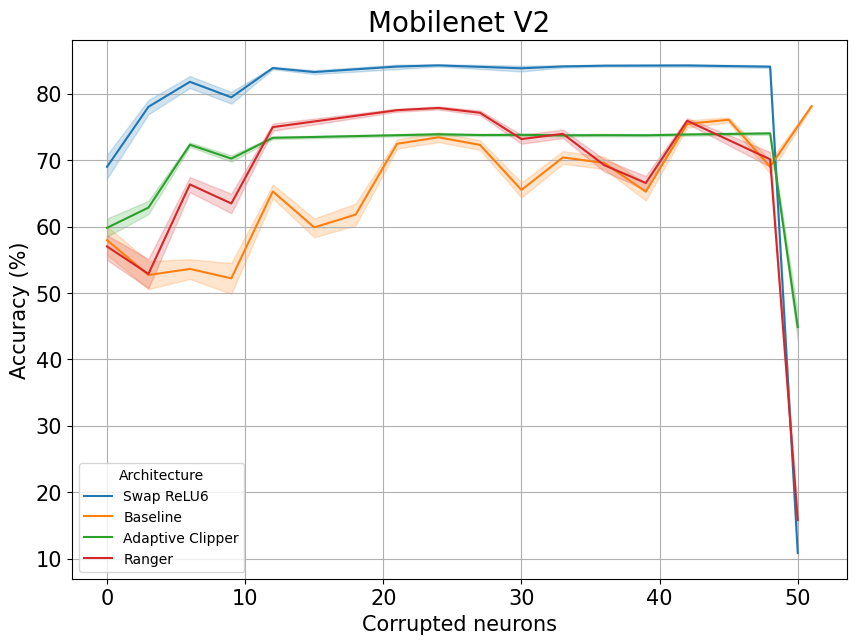

In [26]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.lineplot(data=general_report[general_report['bit_faulty_pos']==30], x='layer', y='fault_ACC@1', hue='Architecture', ax = ax)
# sns.boxplot(data=general_report[general_report['bit_faulty_pos']==30], x='neuron_fault_rate', y='fault_ACC@1', hue='Architecture', ax = ax)
ax.set_title('Mobilenet V2', fontsize=20)
ax.grid()
ax.set_ylabel('Accuracy (%)', fontsize=15)
ax.set_xlabel('Corrupted neurons', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

## NaN values in NN output

In [27]:
new_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1529790 entries, 0 to 1529789
Data columns (total 34 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Unnamed: 0      1474095 non-null  object 
 1   FaultID         1474095 non-null  object 
 2   imID            1474095 non-null  float64
 3   layer           1474095 non-null  float64
 4   kernel          1474095 non-null  float64
 5   channel         1474095 non-null  float64
 6   row             1474095 non-null  float64
 7   col             1474095 non-null  float64
 8   bitmask         1474095 non-null  float64
 9   G_Target        1474095 non-null  float64
 10  F_clas0         1474095 non-null  float64
 11  F_clas1         1474095 non-null  float64
 12  F_clas2         1474095 non-null  float64
 13  F_clas3         1474095 non-null  float64
 14  F_clas4         1474095 non-null  float64
 15  F_pred0         1471569 non-null  float64
 16  F_pred1         1471569 non-null  fl

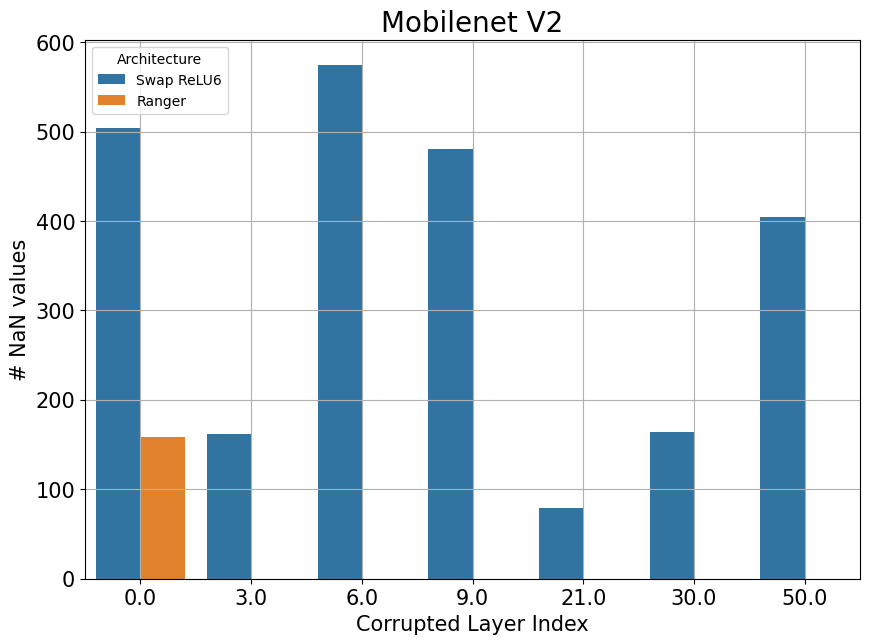

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.countplot(data = new_report.query("F_pred0.isnull()"), x='layer', hue='Architecture',  ax = ax)

ax.set_title('Mobilenet V2', fontsize=20)
ax.grid()
ax.set_ylabel('# NaN values', fontsize=15)
ax.set_xlabel('Corrupted Layer Index', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

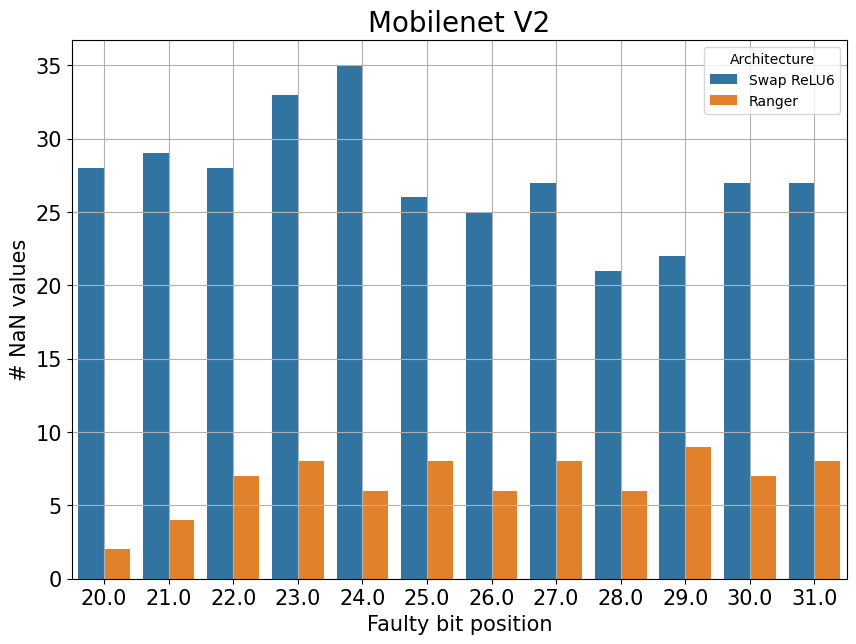

In [29]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.countplot(data = new_report.query("F_pred0.isnull()"), x='bit_faulty_pos', hue='Architecture',  ax = ax)

ax.set_title('Mobilenet V2', fontsize=20)
ax.grid()
ax.set_ylabel('# NaN values', fontsize=15)
ax.set_xlabel('Faulty bit position', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

## Infinite values in NN output

In [30]:
new_report_numeric = new_report.apply(pd.to_numeric, errors='coerce')
infinity_mask = np.isinf(new_report_numeric)
infinity_report = new_report[infinity_mask.any(axis=1)]

ValueError: min() arg is an empty sequence

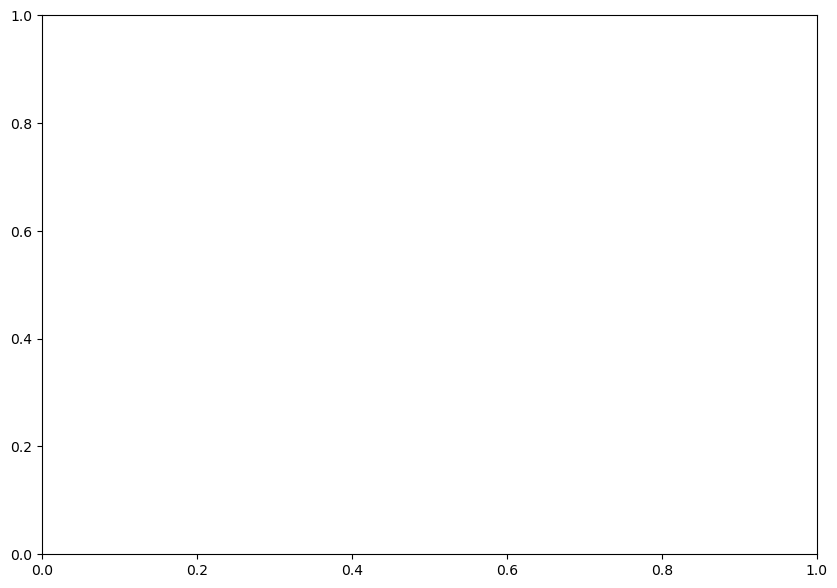

In [31]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.countplot(data = infinity_report, x='bit_faulty_pos', hue='Architecture',  ax = ax)

ax.set_title('Mobilenet V2', fontsize=20)
ax.grid()
ax.set_ylabel('# NaN values', fontsize=15)
ax.set_xlabel('Faulty bit position', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

## Top1 - Top2 
#### It is worth to explore also this metric becuase, when models are deployed into a CPS, if the difference between the top1 and top2 predictions are too close, so if the model is not confident enough on the top1 prediction, it is discarded.
(A reference is needed)
# Here intinite and nan values must be discarded

In [31]:
new_report_numeric = new_report.apply(pd.to_numeric, errors='coerce')
infinity_mask = np.isinf(new_report_numeric)
non_infinity_report = new_report[~infinity_mask.any(axis=1)]

In [33]:
non_infinity_report['top_diff'] = abs(non_infinity_report['F_pred0'] - non_infinity_report['F_pred1'])/abs(non_infinity_report['F_pred0']+non_infinity_report['F_pred1']+non_infinity_report['F_pred2']+non_infinity_report['F_pred3']+non_infinity_report['F_pred4'])

In [34]:
non_infinity_report['top_diff'].describe()

count    4.373100e+04
mean     1.079753e+42
std      2.406230e+43
min      3.311852e-04
25%      1.058863e+01
50%      5.471645e+03
75%      6.864974e+10
max      7.136238e+44
Name: top_diff, dtype: float64

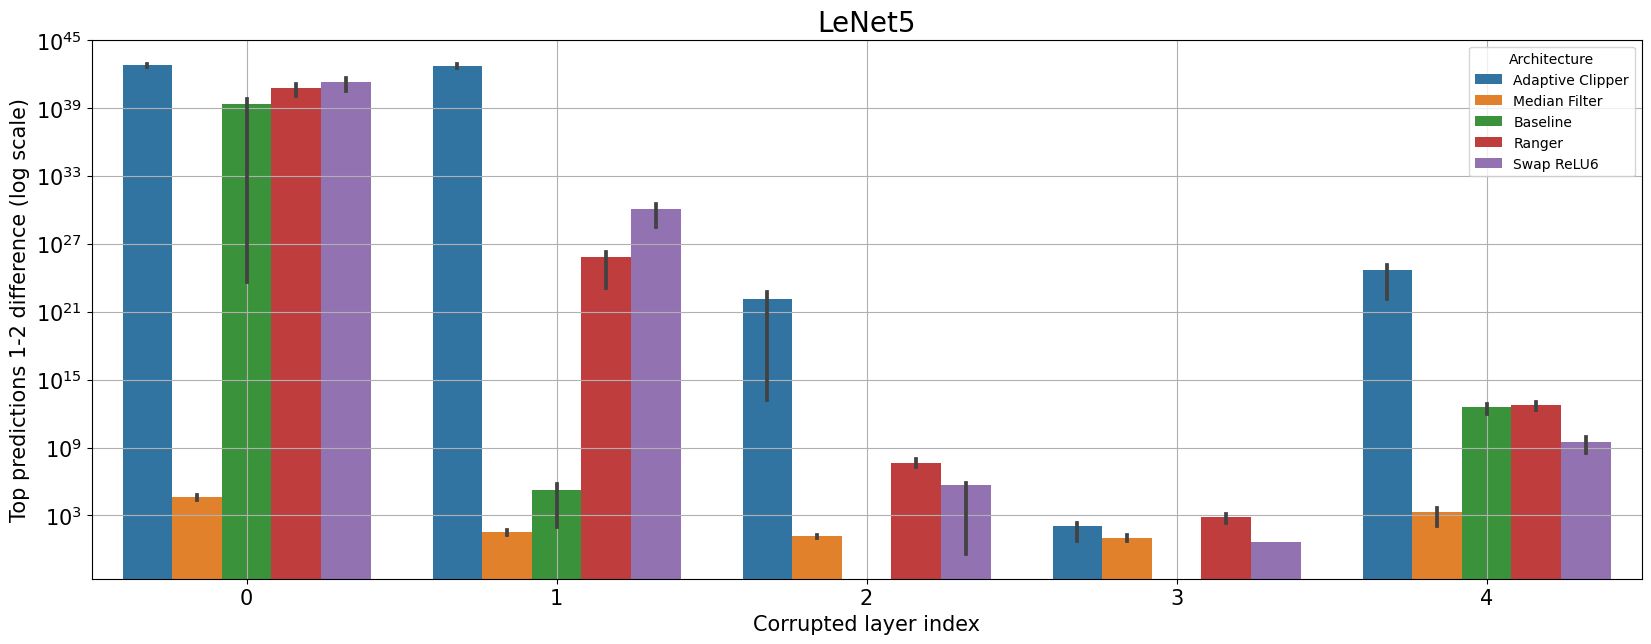

In [40]:
fig, ax = plt.subplots(1,1,figsize=(20,7))
sns.barplot(data=non_infinity_report, x='layer', y='top_diff', hue='Architecture', ax = ax)
# sns.boxplot(data=general_report[general_report['bit_faulty_pos']==30], x='neuron_fault_rate', y='fault_ACC@1', hue='Architecture', ax = ax)
ax.set_title('Mobilenet V2', fontsize=20)
ax.grid()
ax.set_yscale('log')
ax.set_ylabel('Top predictions 1-2 difference (log scale)', fontsize=15)
ax.set_xlabel('Corrupted layer index', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

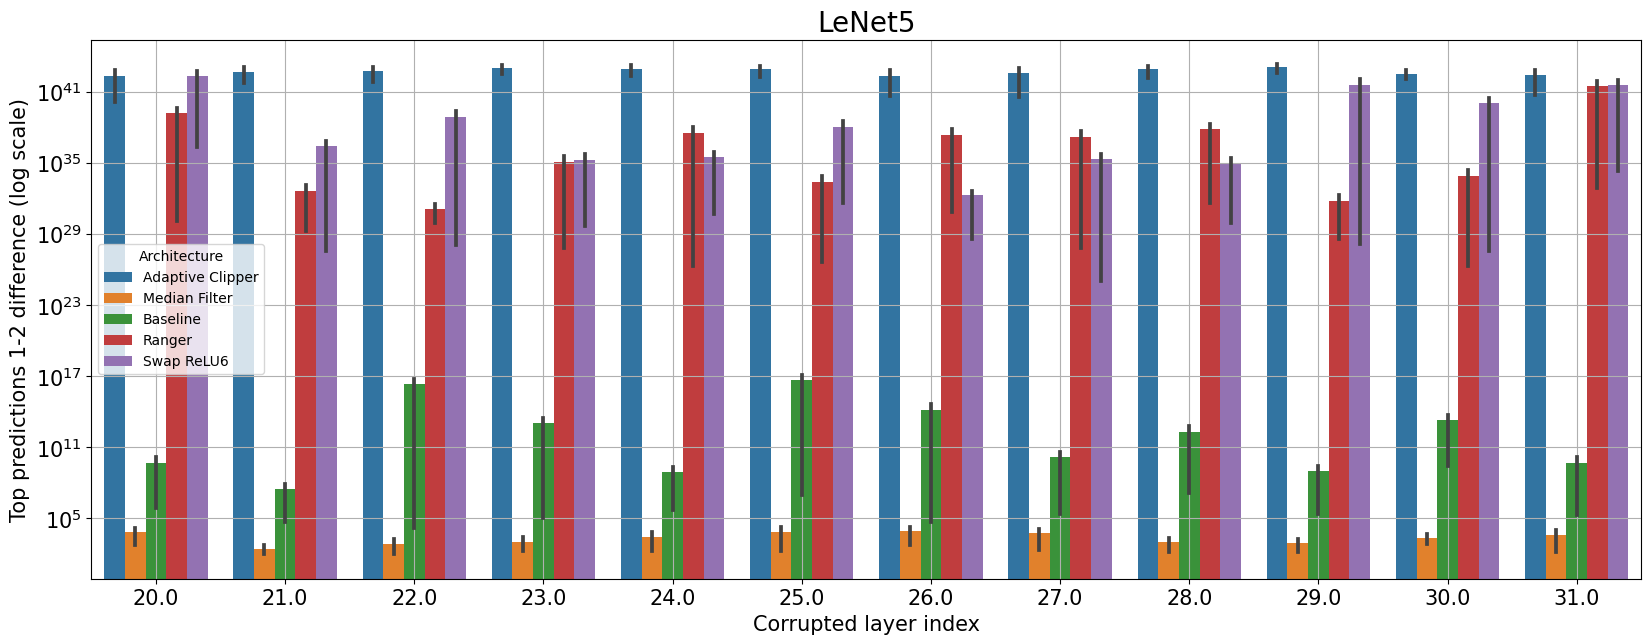

In [41]:
fig, ax = plt.subplots(1,1,figsize=(20,7))
sns.barplot(data=non_infinity_report, x='bit_faulty_pos', y='top_diff', hue='Architecture', ax = ax)
# sns.boxplot(data=general_report[general_report['bit_faulty_pos']==30], x='neuron_fault_rate', y='fault_ACC@1', hue='Architecture', ax = ax)
ax.set_title('Mobilenet V2', fontsize=20)
ax.grid()
ax.set_yscale('log')
ax.set_ylabel('Top predictions 1-2 difference (log scale)', fontsize=15)
ax.set_xlabel('Corrupted layer index', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

### Distribution of different calsses occurences 

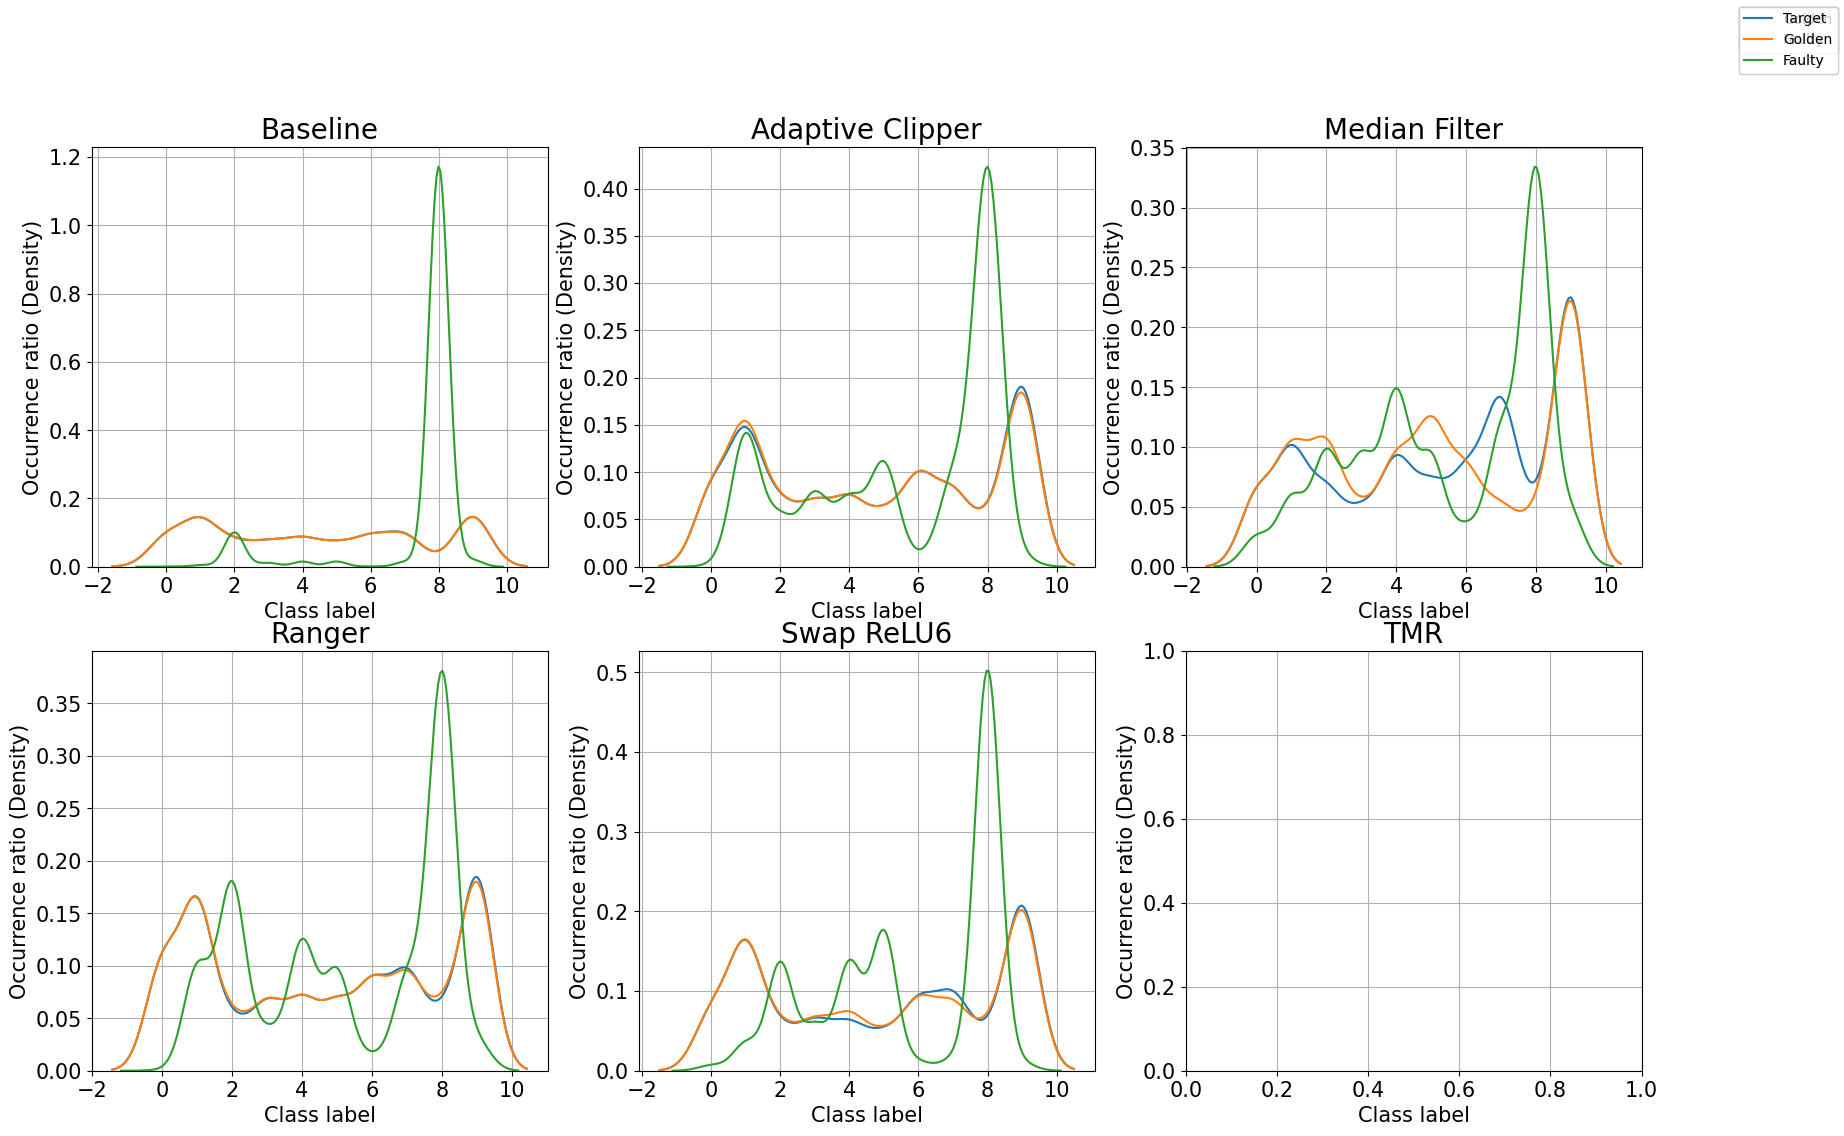

In [42]:
fig, ax = plt.subplots(2,3,figsize=(20,12))
sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='Baseline'], x='G_Target', ax = ax[0][0], common_norm=True)
sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='Baseline'], x='G_clas0', ax = ax[0][0], common_norm=True)
sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='Baseline'], x='F_clas0', ax = ax[0][0], common_norm=True)
ax[0][0].set_title('Baseline', fontsize=20)
ax[0][0].grid()
ax[0][0].set_ylabel('Occurrence ratio (Density)', fontsize=15)
ax[0][0].set_xlabel('Class label', fontsize=15)
ax[0][0].tick_params(axis='x', labelsize=15)
ax[0][0].tick_params(axis='y', labelsize=15)
fig.legend(labels = ['Target','Golden', 'Faulty'])

sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='Adaptive Clipper'], x='G_Target', ax = ax[0][1], common_norm= True)
sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='Adaptive Clipper'], x='G_clas0', ax = ax[0][1], common_norm= True)
sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='Adaptive Clipper'], x='F_clas0', ax = ax[0][1], common_norm= True)
ax[0][1].set_title('Adaptive Clipper', fontsize=20)
ax[0][1].grid()
ax[0][1].set_ylabel('Occurrence ratio (Density)', fontsize=15)
ax[0][1].set_xlabel('Class label', fontsize=15)
ax[0][1].tick_params(axis='x', labelsize=15)
ax[0][1].tick_params(axis='y', labelsize=15)
fig.legend(labels = ['Golden', 'Faulty'])

sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='Median Filter'], x='G_Target', ax = ax[0][2], common_norm= True, common_grid=True)
sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='Median Filter'], x='G_clas0', ax = ax[0][2], common_norm= True, common_grid=True)
sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='Median Filter'], x='F_clas0', ax = ax[0][2], common_norm= True, common_grid=True)
ax[0][2].set_title('Median Filter', fontsize=20)
ax[0][2].grid()
ax[0][2].set_ylabel('Occurrence ratio (Density)', fontsize=15)
ax[0][2].set_xlabel('Class label', fontsize=15)
ax[0][2].tick_params(axis='x', labelsize=15)
ax[0][2].tick_params(axis='y', labelsize=15)
fig.legend(labels = ['Golden', 'Faulty'])

sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='Ranger'], x='G_Target', ax = ax[1][0], common_norm= True)
sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='Ranger'], x='G_clas0', ax = ax[1][0], common_norm= True)
sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='Ranger'], x='F_clas0', ax = ax[1][0], common_norm= True)
ax[1][0].set_title('Ranger', fontsize=20)
ax[1][0].grid()
ax[1][0].set_ylabel('Occurrence ratio (Density)', fontsize=15)
ax[1][0].set_xlabel('Class label', fontsize=15)
ax[1][0].tick_params(axis='x', labelsize=15)
ax[1][0].tick_params(axis='y', labelsize=15)
fig.legend(labels = ['Golden', 'Faulty'])

sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='Swap ReLU6'], x='G_Target', ax = ax[1][1], common_norm=True)
sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='Swap ReLU6'], x='G_clas0', ax = ax[1][1], common_norm=True)
sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='Swap ReLU6'], x='F_clas0', ax = ax[1][1], common_norm=True)
ax[1][1].set_title('Swap ReLU6', fontsize=20)
ax[1][1].grid()
ax[1][1].set_ylabel('Occurrence ratio (Density)', fontsize=15)
ax[1][1].set_xlabel('Class label', fontsize=15)
ax[1][1].tick_params(axis='x', labelsize=15)
ax[1][1].tick_params(axis='y', labelsize=15)
fig.legend(labels = ['Golden', 'Faulty'])

sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='TMR'], x='G_Target', ax = ax[1][2], common_norm=True)
sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='TMR'], x='G_clas0', ax = ax[1][2], common_norm=True)
sns.kdeplot(data=non_infinity_report[non_infinity_report['Architecture']=='TMR'], x='F_clas0', ax = ax[1][2], common_norm=True)
ax[1][2].set_title('TMR', fontsize=20)
ax[1][2].grid()
ax[1][2].set_ylabel('Occurrence ratio (Density)', fontsize=15)
ax[1][2].set_xlabel('Class label', fontsize=15)
ax[1][2].tick_params(axis='x', labelsize=15)
ax[1][2].tick_params(axis='y', labelsize=15)
fig.legend(labels = ['Target','Golden', 'Faulty'])